<a href="https://colab.research.google.com/github/Angelvj/TFG/blob/main/code/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
!pip install -q -U keras-tuner
import kerastuner as kt

import keras
import keras.layers as layers
import numpy as np
import tensorflow as tf
import keras as k
import sklearn
import nibabel as nib
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, MaxPool3D, GlobalAveragePooling3D, AveragePooling3D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import SGD

import time
import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import svm
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import LinearSVC
from sklearn import decomposition
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

     |████████████████████████████████| 71kB 7.2MB/s 


# Load data and impute NaN values

In [2]:
# Load data
COLAB = True
preprocessed = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = '/content/drive/My Drive/Machine learning/data'
  if preprocessed:
      DATA_PATH += '/preprocessed'

else: 
  DATA_PATH = '../../data'

def load_image(filename):    
    """
    
    Parameters
    ----------
    filename : str
        relative path to de image

    Returns
    -------
    img : numpy ndarray
        array containing the image
        
    """
    img = nib.load(filename)
    img = np.asarray(img.dataobj)
    img = np.expand_dims(img, axis=3)
    return img


def load_images_from_dir(dirname):
    """
    
    Parameters
    ----------
    dirname : str
        name of the directory containing images.

    Returns
    -------
    imgs : numpy ndarray
        array containing all of the images in the folder.

    """
    imgs = []

    for filename in tqdm(glob.glob(dirname + '/*.nii')):
        imgs.append(load_image(filename))
        
    imgs = np.stack(imgs) # All images over the new first dimension
    return imgs

def load_data(dirs_dict, categorical = False):
    """
    
    Parameters
    ----------
    dirs_dict : dictionary
        dictionary containing data folders name, and the label for the images
        on each forlder.

    Returns
    -------
    x : numpy ndarray
        array containing the images.
    y : numpy ndarray

        array containig the label of each image.

    """
    first = True
    for key, value in dirs_dict.items():
        if first:
            X = load_images_from_dir(value)
            # ¿necesario float32 o puedo usar uint8?
            y = np.full((X.shape[0]), key, dtype=np.float32)
            first = False
        else:
            X_current = load_images_from_dir(value)
            X = np.concatenate((X, X_current), axis=0)
            y = np.concatenate((y, np.full((X_current.shape[0]), key, dtype=np.float32)), axis=0)
            
    if categorical:
        y = k.utils.to_categorical(y)
    
    return X, y

def impute_nan_values(imgs, inplace=True):
    # Replace nan values with 0
    return np.nan_to_num(imgs, copy = not inplace)

# Load PET images with labels
print('\n --- Loading PET data --- \n')
time.sleep(0.5)
X, y = load_data({0: DATA_PATH + "/ppNOR/PET", 
                  1: DATA_PATH + "/ppAD/PET",
                  2: DATA_PATH + "/ppMCI/PET"})

# Separate into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)

impute_nan_values(X_train)
impute_nan_values(X_test)

print('\n --- PET data loaded --- \n')

Mounted at /content/drive

 --- Loading PET data --- 



100%|██████████| 111/111 [00:51<00:00,  2.16it/s]



 --- PET data loaded --- 



# Preprocessing data

In [3]:
def max_intensity_normalization(X, percentage, inplace=True):

    if not inplace:
        X = X.copy()

    volume_shape = X[0].shape
    n_max_values = int((volume_shape[0]*volume_shape[1]*volume_shape[2]*percentage)/100)

    for i in range(len(X)):
        n_max_idx = np.unravel_index((X[i]).argsort(axis=None)[-n_max_values:], X[i].shape)
        mean = np.mean(X[i][n_max_idx])
        X[i] /= mean

    if not inplace:
        return X

X_train_n = max_intensity_normalization(X_train, 1, inplace=False)

# Testing SVM

In [ ]:
# # Test SVM classifier first
# x_tr, x_val, y_tr, y_val = train_test_split(X_train_n, y_train, test_size = 0.2, stratify = y_train)

# x_tr_1D = np.empty((x_tr.shape[0], x_tr.shape[1]*x_tr.shape[2]*x_tr.shape[3]))

# # Convert each image to a single dimension ndarray
# for i in range(len(x_tr)):
#     x_tr_1D[i] = x_tr[i].flatten()

# x_val_1D = np.empty((x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3]))
# for i in range(len(y_val)):
#     x_val_1D[i] = x_val[i].flatten()

# # clf = svm.SVC(kernel='linear', C=0.8)
# # clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=0.05)) # 0.48 en 5 tiradas
# # clf.fit(x_tr_1D, y_tr)

# print(clf.score(x_tr_1D, y_tr))
# print(clf.score(x_val_1D, y_val))

# Functions for training models

In [4]:
def learning_curve(hist):
    history_dict = hist.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.ylim(0 - 0.1, 6 + 0.1)
    plt.legend(['Training', 'Validation'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.ylim(0 -0.1, 1 + 0.1)
    plt.legend(['Training','Validation'])
    plt.show()

In [5]:
def cross_validate(model, x_train, y_train, num_folds, opt, batch_size, epochs, 
                   verbose=0, show_history=False, return_results=True, show_mean_history=True,
                   label_smoothing=0):

    # Creamos un objeto kfold, especificando el número de segmentos que queremos utilizar,
    # además utilizamos shuffle true, para que los num_folds conjuntos disjuntos se seleccionen
    # de forma aleatoria, evitando de esta forma problemas que podría haber si los datos
    # estuvieran ordenados siguiendo una cierta distribución

    skfold = StratifiedKFold(n_splits = num_folds, shuffle=True)

    # loss = tf.keras.losses.CategoricalCrossentropy(
    # from_logits=False, label_smoothing=label_smoothing,name='categorical_crossentropy')

    model.compile(loss = k.losses.categorical_crossentropy, optimizer=opt,
                metrics = ['accuracy'])
    
    # model.compile(loss = loss, optimizer=opt,
    #             metrics = ['accuracy'])

    initial_weights = model.get_weights()

    acc_per_fold = []
    loss_per_fold = []
    acc_per_fold_tr = []
    loss_per_fold_tr = []

    fold_no = 1

    mean_history = np.zeros((4, epochs))

    for kfold_train, kfold_test in skfold.split(x_train, y_train):

        # En cada fold, comenzamos con los pesos iniciales. Tratamos de que las 5
        # folds sean lo más independientes posible.
        model.set_weights(initial_weights)

        if verbose:
            print('------------------------------------------------------------------------')
            print(f'Entrenando para el fold {fold_no} ...')

        history = model.fit(x_train[kfold_train], 
                            k.utils.to_categorical(y_train[kfold_train]), 
                            batch_size= batch_size,
                            epochs=epochs, verbose = verbose, 
                            validation_data = (x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]))
                            )

        if show_history:
            # Mostramos la evolución en cada fold
            learning_curve(history)

        if show_mean_history:
            mean_history[0] += history.history['loss']
            mean_history[1] += history.history['val_loss']
            mean_history[2] += history.history['accuracy']
            mean_history[3] += history.history['val_accuracy']

        # Calculamos la bondad del modelo para el fold reservado para testing
        scores = model.evaluate(x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]), verbose=0)
        scores_train = model.evaluate(x_train[kfold_train], k.utils.to_categorical(y_train[kfold_train]), verbose=0)

        # Vamos guardando el accuracy y pérdida para cada fold
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        acc_per_fold_tr.append(scores_train[1])
        loss_per_fold_tr.append(scores_train[0])

        if verbose:
            print(f'Resultado para el fold {fold_no}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

        fold_no += 1

    # ==  Mostramos los resultados para cada fold == 
    if verbose:
        print('------------------------------------------------------------------------')
        print('Resultados por cada fold')
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')


    print('------------------------------------------------------------------------')
    print('Media de los resultados, por época:')
    if show_mean_history:
        plt.plot(mean_history[0]/num_folds)
        plt.plot(mean_history[1]/num_folds)
        plt.ylabel('Mean loss')
        plt.xlabel('Epochs')
        plt.ylim(0 - 0.1, 6 + 0.1)
        plt.legend(['Training', 'Validation'])
        plt.show()

        plt.plot(mean_history[2]/num_folds)
        plt.plot(mean_history[3]/num_folds)
        plt.ylabel('Mean accuracy')
        plt.xlabel('Epochs')
        plt.ylim(0 -0.1, 1 + 0.1)
        plt.legend(['Training','Validation'])
        plt.show()

    # Calculamos y mostramos los valores medios
    mean_acc_cv = np.mean(acc_per_fold)
    mean_loss_cv = np.mean(loss_per_fold)
    mean_acc_tr = np.mean(acc_per_fold_tr)
    mean_loss_tr = np.mean(loss_per_fold_tr)

    if not return_results:
        print('------------------------------------------------------------------------')
        print('Media de los resultados para todos los folds:')
        print(f'> Accuracy: {np.mean(acc_per_fold)}')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print(f'> Train accuracy: {np.mean(acc_per_fold_tr)}')
        print(f'> Train accuracy: {np.mean(loss_per_fold_tr)}')
        print('------------------------------------------------------------------------')

    else:
        return mean_acc_tr, mean_loss_tr, mean_acc_cv, mean_loss_cv

In [ ]:
!rm -r ./model\_two

rm: cannot remove './model_two': No such file or directory


# Hypertuning models

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[4])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
'''
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256. The optimal number of filters in the convolutional layer is 32. The optimal learning 
rate for the optimizer is 0.0001. The optimal batch size is 4
'''
def model_zero_builder(hp, width=79, height=95, depth=68):
     
    model = keras.Sequential()

    hp_filters = hp.Choice('filters', values = [8, 16, 32, 64])
    model.add(Conv3D(filters=hp_filters, kernel_size=3, activation="relu", input_shape = (width, height, depth, 1)))
    model.add(MaxPooling3D(pool_size=2))

    model.add(Flatten())

    hp_units = hp.Choice('units', values=[64, 128, 256])
    model.add(Dense(units=hp_units, activation="relu"))

    model.add(Dense(units=3, activation="softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])

    return model

# tuner = MyTuner(model_zero_builder, 
#                 objective='val_loss',
#                 project_name = 'model_zero',
#                 max_trials = 100)

# tuner.search(X_train_n, k.utils.to_categorical(y_train), epochs=30, validation_split=0.2)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')}. The optimal number of filters in the convolutional layer is
# {best_hps.get('filters')}. The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
#  The optimal batch size is {best_hps.get('batch_size')}
# """)

'''
Batch size: 32
The hyperparameter search is complete. Optimal no. filters: 16,
64, 128. Optimal filter's size:
5, 5, 5. Optimal
units in fully connected: 256
--- Otra prueba ---
Batch size: 4
objective : val_accuracy
Filters: 16 , 64, 32
Size: 3, 3, 3
units : 256
'''
def model_two_builder(hp, width=79, height=95, depth=68):
    inputs = k.Input((width, height, depth, 1))

    hp_filter_size_1 = hp.Choice('ks_1', values=[3,5])
    hp_filters_1 = hp.Choice('filters_1', values=[16, 32])
    x = Conv3D(filters=hp_filters_1, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)

    hp_filter_size_2 = hp.Choice('ks_2', values=[3,5])
    hp_filters_2 = hp.Choice('filters_2', values=[32, 64])
    x = Conv3D(filters=hp_filters_2, kernel_size=hp_filter_size_2, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    hp_filter_size_3 = hp.Choice('ks_3', values=[3,5])
    hp_filters_3 = hp.Choice('filters_3', values=[32, 64, 128])
    x = Conv3D(filters=hp_filters_3, kernel_size=hp_filter_size_3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    hp_units = hp.Choice('units', values=[64, 128, 256])
    x = Dense(units=hp_units, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="second_model_builder")


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss = keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

# tuner = MyTuner(model_two_builder, 
#                 objective='val_loss',
#                 project_name = 'model_two',
#                 max_trials = 150)

# tuner.search(X_train_n, k.utils.to_categorical(y_train), epochs=30, validation_split=0.2)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. Optimal no. filters: {best_hps.get('filters_1')},
# {best_hps.get('filters_2')}, {best_hps.get('filters_3')}. Optimal filter's size:
# {best_hps.get('ks_1')}, {best_hps.get('ks_2')}, {best_hps.get('ks_3')}. Optimal
# units in fully connected: {best_hps.get('units')}
# """)

INFO:tensorflow:Reloading Oracle from existing project ./model_two/oracle.json
INFO:tensorflow:Reloading Tuner from ./model_two/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. Optimal no. filters: 16,
64, 128. Optimal filter's size:
5, 5, 5. Optimal
units in fully connected: 256



# Define models


 --------------- MODELO 2 ------------------

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 79, 95, 68, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 75, 91, 64, 16)    2016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 37, 45, 32, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 45, 32, 16)    64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 33, 41, 28, 64)    128064    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 20, 14, 64)    0         
_________________________________________________________________
batch_normal

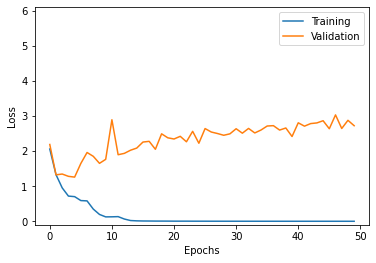

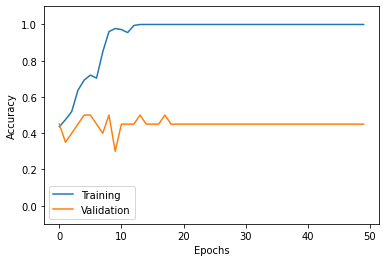

Resultado para el fold 1: loss de 2.7252776622772217; accuracy de 44.999998807907104%
------------------------------------------------------------------------
Entrenando para el fold 2 ...
Epoch 1/50
45/45 [==============================] - 2s 44ms/step - loss: 3.9068 - accuracy: 0.3184 - val_loss: 2.2842 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 1.2680 - accuracy: 0.4860 - val_loss: 1.2965 - val_accuracy: 0.3000
Epoch 3/50
45/45 [==============================] - 2s 43ms/step - loss: 1.0577 - accuracy: 0.5140 - val_loss: 1.2195 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9797 - accuracy: 0.5698 - val_loss: 1.0135 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9399 - accuracy: 0.5251 - val_loss: 1.1211 - val_accuracy: 0.4500
Epoch 6/50
45/45 [==============================] - 2s 44ms/step - loss: 0.7740 - accuracy: 0.6257 - val_l

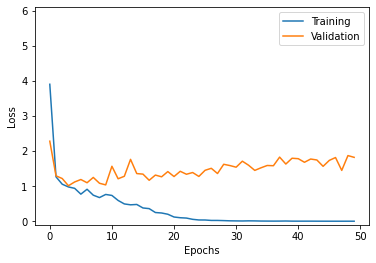

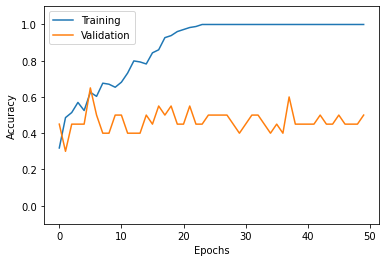

Resultado para el fold 2: loss de 1.8233535289764404; accuracy de 50.0%
------------------------------------------------------------------------
Entrenando para el fold 3 ...
Epoch 1/50
45/45 [==============================] - 2s 44ms/step - loss: 4.0773 - accuracy: 0.3352 - val_loss: 2.3501 - val_accuracy: 0.3500
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 1.5601 - accuracy: 0.3855 - val_loss: 1.7753 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 43ms/step - loss: 1.0781 - accuracy: 0.5084 - val_loss: 1.5294 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 1.0176 - accuracy: 0.5251 - val_loss: 1.9179 - val_accuracy: 0.3500
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9518 - accuracy: 0.5419 - val_loss: 0.9864 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 2s 43ms/step - loss: 0.8199 - accuracy: 0.6201 - val_loss: 1.1800 - 

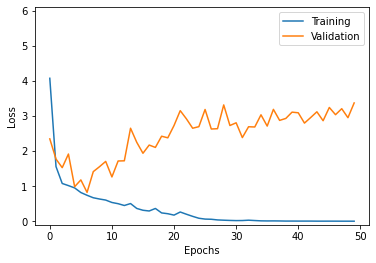

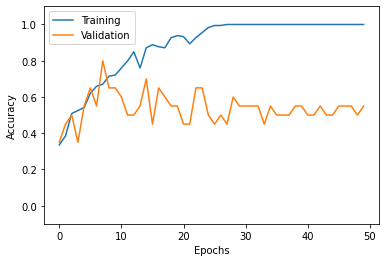

Resultado para el fold 3: loss de 3.37444806098938; accuracy de 55.000001192092896%
------------------------------------------------------------------------
Entrenando para el fold 4 ...
Epoch 1/50
45/45 [==============================] - 2s 44ms/step - loss: 4.2585 - accuracy: 0.3966 - val_loss: 2.9686 - val_accuracy: 0.3500
Epoch 2/50
45/45 [==============================] - 2s 43ms/step - loss: 2.1673 - accuracy: 0.3240 - val_loss: 1.4711 - val_accuracy: 0.3500
Epoch 3/50
45/45 [==============================] - 2s 44ms/step - loss: 1.1815 - accuracy: 0.4637 - val_loss: 1.0732 - val_accuracy: 0.6000
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 0.8936 - accuracy: 0.5642 - val_loss: 0.9024 - val_accuracy: 0.6000
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.7888 - accuracy: 0.6313 - val_loss: 0.7926 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 2s 43ms/step - loss: 0.7867 - accuracy: 0.6536 - val_los

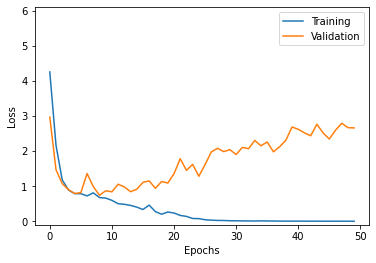

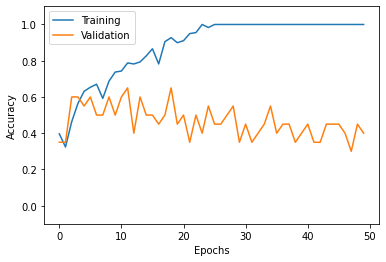

Resultado para el fold 4: loss de 2.662595748901367; accuracy de 40.00000059604645%
------------------------------------------------------------------------
Entrenando para el fold 5 ...
Epoch 1/50
45/45 [==============================] - 2s 44ms/step - loss: 2.6071 - accuracy: 0.3687 - val_loss: 1.4261 - val_accuracy: 0.4000
Epoch 2/50
45/45 [==============================] - 2s 43ms/step - loss: 1.3145 - accuracy: 0.4413 - val_loss: 1.3676 - val_accuracy: 0.4500
Epoch 3/50
45/45 [==============================] - 2s 43ms/step - loss: 1.0409 - accuracy: 0.4804 - val_loss: 1.0882 - val_accuracy: 0.4500
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9152 - accuracy: 0.5978 - val_loss: 1.0889 - val_accuracy: 0.5500
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9203 - accuracy: 0.5698 - val_loss: 0.9596 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 2s 44ms/step - loss: 0.7661 - accuracy: 0.6425 - val_los

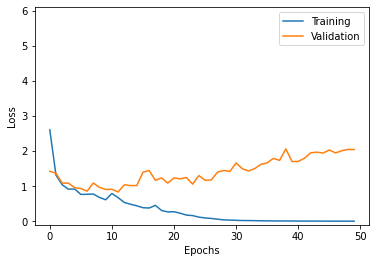

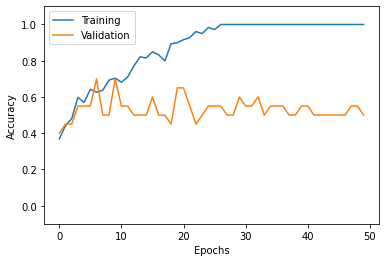

Resultado para el fold 5: loss de 2.045348882675171; accuracy de 50.0%
------------------------------------------------------------------------
Entrenando para el fold 6 ...
Epoch 1/50
45/45 [==============================] - 2s 44ms/step - loss: 3.1779 - accuracy: 0.3855 - val_loss: 1.1423 - val_accuracy: 0.3500
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 1.1903 - accuracy: 0.3799 - val_loss: 1.0687 - val_accuracy: 0.5000
Epoch 3/50
45/45 [==============================] - 2s 44ms/step - loss: 1.0534 - accuracy: 0.5307 - val_loss: 1.1165 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 1.0294 - accuracy: 0.5475 - val_loss: 1.6156 - val_accuracy: 0.4000
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9211 - accuracy: 0.5978 - val_loss: 0.9983 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 2s 44ms/step - loss: 0.8674 - accuracy: 0.6313 - val_loss: 1.1465 - v

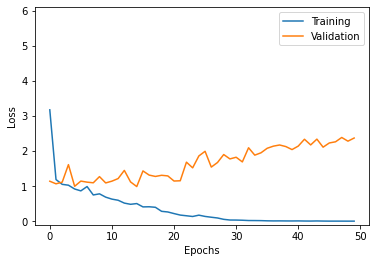

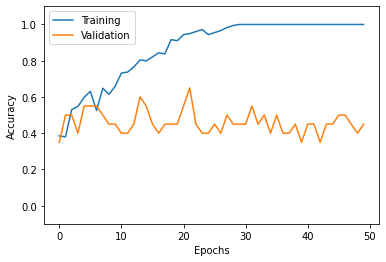

Resultado para el fold 6: loss de 2.3743014335632324; accuracy de 44.999998807907104%
------------------------------------------------------------------------
Entrenando para el fold 7 ...
Epoch 1/50
45/45 [==============================] - 2s 45ms/step - loss: 4.0474 - accuracy: 0.3464 - val_loss: 2.0783 - val_accuracy: 0.3000
Epoch 2/50
45/45 [==============================] - 2s 43ms/step - loss: 1.3453 - accuracy: 0.5028 - val_loss: 3.1914 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 2s 44ms/step - loss: 1.1472 - accuracy: 0.4749 - val_loss: 1.4810 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 2s 44ms/step - loss: 0.8612 - accuracy: 0.6034 - val_loss: 1.5352 - val_accuracy: 0.2500
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.8584 - accuracy: 0.5754 - val_loss: 1.4199 - val_accuracy: 0.4000
Epoch 6/50
45/45 [==============================] - 2s 43ms/step - loss: 0.7243 - accuracy: 0.6425 - val_l

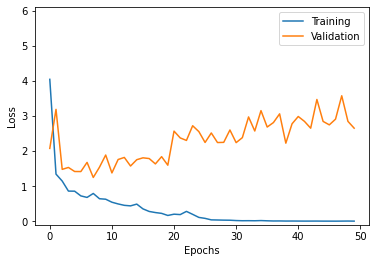

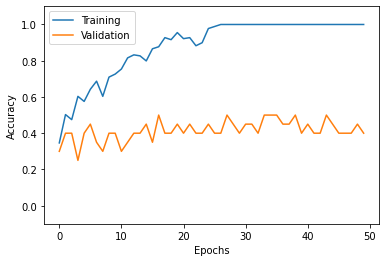

Resultado para el fold 7: loss de 2.654966115951538; accuracy de 40.00000059604645%
------------------------------------------------------------------------
Entrenando para el fold 8 ...
Epoch 1/50
45/45 [==============================] - 2s 45ms/step - loss: 3.9924 - accuracy: 0.3631 - val_loss: 1.4644 - val_accuracy: 0.5500
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 1.4691 - accuracy: 0.4860 - val_loss: 1.1441 - val_accuracy: 0.6500
Epoch 3/50
45/45 [==============================] - 2s 44ms/step - loss: 1.2715 - accuracy: 0.4246 - val_loss: 1.2669 - val_accuracy: 0.4000
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9815 - accuracy: 0.5698 - val_loss: 1.2882 - val_accuracy: 0.5000
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9002 - accuracy: 0.5698 - val_loss: 1.1536 - val_accuracy: 0.5500
Epoch 6/50
45/45 [==============================] - 2s 43ms/step - loss: 0.7677 - accuracy: 0.6536 - val_los

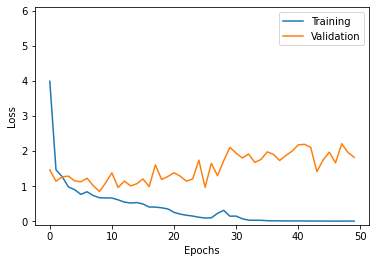

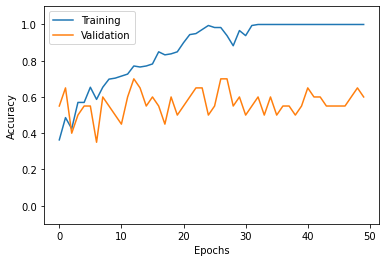

Resultado para el fold 8: loss de 1.8245980739593506; accuracy de 60.00000238418579%
------------------------------------------------------------------------
Entrenando para el fold 9 ...
Epoch 1/50
45/45 [==============================] - 2s 45ms/step - loss: 4.4104 - accuracy: 0.3743 - val_loss: 1.2957 - val_accuracy: 0.4500
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 1.6443 - accuracy: 0.4078 - val_loss: 0.9846 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 2s 43ms/step - loss: 1.0624 - accuracy: 0.4469 - val_loss: 0.8363 - val_accuracy: 0.5000
Epoch 4/50
45/45 [==============================] - 2s 44ms/step - loss: 0.9553 - accuracy: 0.5587 - val_loss: 0.8388 - val_accuracy: 0.4500
Epoch 5/50
45/45 [==============================] - 2s 43ms/step - loss: 0.9541 - accuracy: 0.5642 - val_loss: 0.9390 - val_accuracy: 0.6000
Epoch 6/50
45/45 [==============================] - 2s 43ms/step - loss: 0.8497 - accuracy: 0.5866 - val_lo

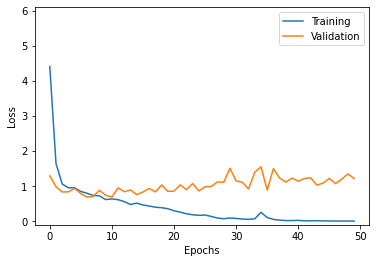

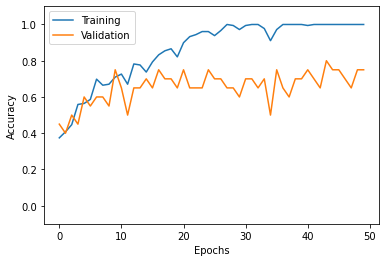

Resultado para el fold 9: loss de 1.2188398838043213; accuracy de 75.0%
------------------------------------------------------------------------
Entrenando para el fold 10 ...
Epoch 1/50
45/45 [==============================] - 2s 45ms/step - loss: 4.0991 - accuracy: 0.4944 - val_loss: 2.2645 - val_accuracy: 0.4737
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 1.4849 - accuracy: 0.4611 - val_loss: 2.5067 - val_accuracy: 0.4737
Epoch 3/50
45/45 [==============================] - 2s 44ms/step - loss: 1.2729 - accuracy: 0.4833 - val_loss: 0.9344 - val_accuracy: 0.5789
Epoch 4/50
45/45 [==============================] - 2s 44ms/step - loss: 0.9970 - accuracy: 0.4944 - val_loss: 1.0435 - val_accuracy: 0.5263
Epoch 5/50
45/45 [==============================] - 2s 45ms/step - loss: 1.0324 - accuracy: 0.5556 - val_loss: 1.0751 - val_accuracy: 0.5263
Epoch 6/50
45/45 [==============================] - 2s 44ms/step - loss: 0.9002 - accuracy: 0.6000 - val_loss: 1.2084 -

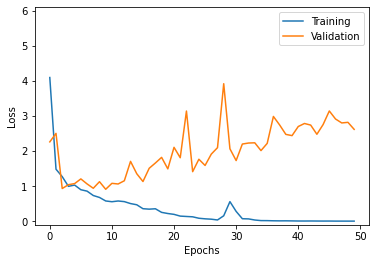

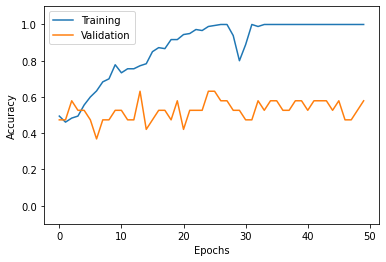

Resultado para el fold 10: loss de 2.621412754058838; accuracy de 57.894736528396606%
------------------------------------------------------------------------
Resultados por cada fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.7252776622772217 - Accuracy: 0.44999998807907104%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8233535289764404 - Accuracy: 0.5%
------------------------------------------------------------------------
> Fold 3 - Loss: 3.37444806098938 - Accuracy: 0.550000011920929%
------------------------------------------------------------------------
> Fold 4 - Loss: 2.662595748901367 - Accuracy: 0.4000000059604645%
------------------------------------------------------------------------
> Fold 5 - Loss: 2.045348882675171 - Accuracy: 0.5%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.3743014335632324 - Accuracy: 0.44999998807907104%
---

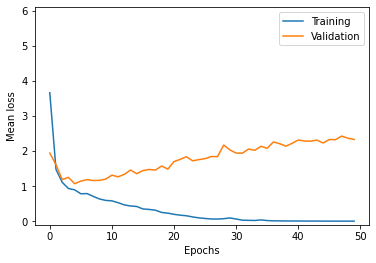

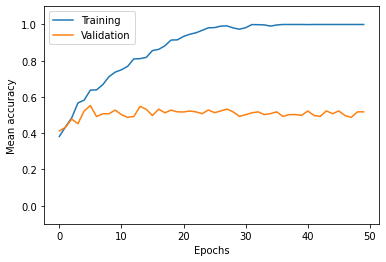

(1.0, 0.003546714870026335, 0.5178947389125824, 2.332514214515686)


In [11]:
# CNN MODELS

# Model configuration
sample_shape = (79,95,68,1)
no_classes = 3

def get_model_zero(width=79, height=95, depth=68):
    # Training time (10-fold): 5s per epoch
    # 10-fold cross validation results:
    #                   Val_accuracy                Val_loss                Tr_accuracy         Tr_loss
    # With dropout      0.46842105090618136         1.6831728219985962      0.9446927368640899  0.11225743502145633
    # No dropout        0.473157899081707           1.5029887318611146      1.0                 0.0027088650298537687           
    # No drop. 64u      0.4060526341199875          1.5169294118881225      0.9446927368640899  0.13563219296629542
    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)

    x = MaxPooling3D(pool_size=2)(x)  

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x) 
    # x = Dropout(0.5)(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="model_0")
    return model


def get_model_one(width=79, height=95, depth=68):
    # Training time: 2s per epoch
    # 10-fold cross validation results:
    # Val_accuracy          Val_loss                Tr_accuracy     Tr_loss
    # 0.5028947353363037    1.8094949841499328      1.0             0.001150345930363983
    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)

    x = MaxPooling3D(pool_size=2)(x)  

    x = Conv3D(filters=32, kernel_size=3, activation="relu")(x)

    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x) 

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="model_1")
    return model

def get_model_two(width=79, height=95, depth=68):
    # Training time: 4s per epoch
    # 10-fold cross validation results (batch size 4)
    # Val_accuracy          Val_loss                Tr_accuracy         Tr_loss
    # 0.5628947407007218    1.9413622736930847      0.9435754239559173  0.14153997380053623 (bs 4)
    # 0.5531578928232193    0.9691982746124268      0.7851055264472961  0.52016741335392 (bs 32)
    # (0.9977653622627258, 0.005438578483881429, 0.5015789449214936, 2.429199516773224) --> V2.1
    # (1.0, 0.003546714870026335, 0.5178947389125824, 2.332514214515686) --> V2.2

    '''
    HYPERTUNING results:
    Batch size: 4
    The hyperparameter search is complete. Optimal no. filters: 16,
    64, 128. Optimal filter's size:
    5, 5, 5. 
    Optimal units in fully connected: 256
    '''

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=16, kernel_size=5, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    # x = BatchNormalization()(x) V2.1
    # x = BatchNormalization(momentum=0.0)(x) V2.2

    x = Conv3D(filters=64, kernel_size=5, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    # x = BatchNormalization()(x) V2.1
    # x = BatchNormalization(momentum=0.0)(x) V2.2

    x = Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(units=256, activation="relu")(x)

    outputs = Dense(units=3, activation="softmax")(x)

    model = k.Model(inputs, outputs, name="model_2")
    return model

# Fit model to data
# Batch size of 16 as a standard starting point: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ ?

# print('\n --------------- MODELO 0 ------------------\n')
# # Ya tiene los mejores hiperparámetros ajustados
# model = get_model_zero()
# model.summary()
# results = cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.0001), 4, 50, 
#                verbose = 1, show_history = True)
# print(results)
# keras.backend.clear_session()

# print('\n --------------- MODELO 1 ------------------\n')
# # Ya tiene los mejores hiperparámetros ajustados
# model = get_model_one()
# model.summary()
# results = cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.0001), 4, 10, 
#                verbose = 1, show_history = True)
# print(results)
# keras.backend.clear_session()

print('\n --------------- MODELO 2 ------------------\n')
model = get_model_two()
model.summary()
results = cross_validate(model, X_train_n, y_train, 10, k.optimizers.Adam(lr=0.0001), 4, 50, 
               verbose = 1, show_history = True, label_smoothing=0)
print(results)
keras.backend.clear_session()


# print('\n --------------- MODELO 3 ------------------\n')
# model = get_model(3)
# model.summary()

# # opt = SGD(lr = 0.001, momentum = 0.9, nesterov = True)
# results = cross_validate(model, X_train_n, y_train, 5,  k.optimizers.Adam(), 16, 30, 
#                verbose = 1, show_history = False)
# print(results)
# keras.backend.clear_session()

In [ ]:
# Models to be tested
# def get_first_model(width=79, height=95, depth=68):
#     '''
#     Deeper model, 
#     '''
#     inputs = k.Input((width, height, depth, 1))

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     # x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = GlobalAveragePooling3D()(x)

#     x = Dense(units=512, activation="relu")(x)

#     outputs = Dense(units=3, activation="softmax")(x)

#     model = k.Model(inputs, outputs, name="baseline_3Dcnn")
#     return model

# def get_first_model(width=79, height=95, depth=68):
#     """Build a 3D convolutional neural network model."""

#     inputs = keras.Input((width, height, depth, 1))

#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization(momentum=0.0)(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=512, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)

#     outputs = layers.Dense(units=3, activation="softmax")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")
#     return model


# def get_fourth_model(width=79, height=95, depth=68):

#     inputs = k.Input((width, height, depth, 1))

#     x = Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
#     x = MaxPooling3D(pool_size=2)(x)
#     x = Dropout(0.1)(x)

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     x = Dropout(0.1)(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = MaxPooling3D(pool_size=2)(x)
#     x = Dropout(0.1)(x)

#     x = Flatten()(x)
#     x = Dense(units=256, activation="relu")(x)
#     x = Dropout(0.1)(x)

#     outputs = Dense(units=3, activation="softmax")(x)
#     x = Dropout(0.5)(x)

#     model = k.Model(inputs, outputs, name="baseline_3Dcnn")
#     return model